In [30]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jeftaadriel/osteoarthritis-initiative-oai-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Sanjjey Arumugam\.cache\kagglehub\datasets\jeftaadriel\osteoarthritis-initiative-oai-dataset\versions\1


In [31]:
### Cell 1: Imports & Environment
import os
import random
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


Device: cuda


In [32]:
print(path)

C:\Users\Sanjjey Arumugam\.cache\kagglehub\datasets\jeftaadriel\osteoarthritis-initiative-oai-dataset\versions\1


In [33]:
path_two=path+"\train"

In [34]:
print(path_two)

C:\Users\Sanjjey Arumugam\.cache\kagglehub\datasets\jeftaadriel\osteoarthritis-initiative-oai-dataset\versions\1	rain


In [35]:
# Download dataset with kagglehub
import kagglehub

path = kagglehub.dataset_download("jeftaadriel/osteoarthritis-initiative-oai-dataset")
print("Dataset downloaded at:", path)

DATA_ROOT=path
SAVE_DIR = "./results"
# Define all splits
SPLITS = ["train", "val", "test", "auto_test"]

# Just to verify
for split in SPLITS:
    stage_dirs = [d.name for d in Path(DATA_ROOT, split).iterdir() if d.is_dir()]
    print(f"{split}: {stage_dirs}")


Dataset downloaded at: C:\Users\Sanjjey Arumugam\.cache\kagglehub\datasets\jeftaadriel\osteoarthritis-initiative-oai-dataset\versions\1
train: ['0', '1', '2', '3', '4']
val: ['0', '1', '2', '3', '4']
test: ['0', '1', '2', '3', '4']
auto_test: ['0', '1', '2', '3', '4']


In [36]:
IMG_SIZE = 128
BATCH_SIZE = 32
NZ = 128        # latent vector size
N_STAGES = 5    # 0..4
N_SIDES = 2     # left, right
EPOCHS = 500
LR = 2e-4


In [37]:
class OAIDataset(Dataset):
    def __init__(self, root, split="train", image_size=128):
        self.root = Path(root) / split
        self.samples = []
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])  # [-1,1]
        ])
        for stage_folder in sorted(self.root.iterdir()):
            stage = int(stage_folder.name)  # 0..4
            for img_path in stage_folder.glob("*.png"):
                side = 0  # default: right
                if "_2.png" in img_path.name:
                    side = 1  # left
                self.samples.append((img_path, stage, side))

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        img_path, stage, side = self.samples[idx]
        img = Image.open(img_path).convert("L")
        img = self.transform(img)
        return img, torch.tensor(stage), torch.tensor(side)


Train: 5778 Val: 826 Test: 1656 Auto: 1526


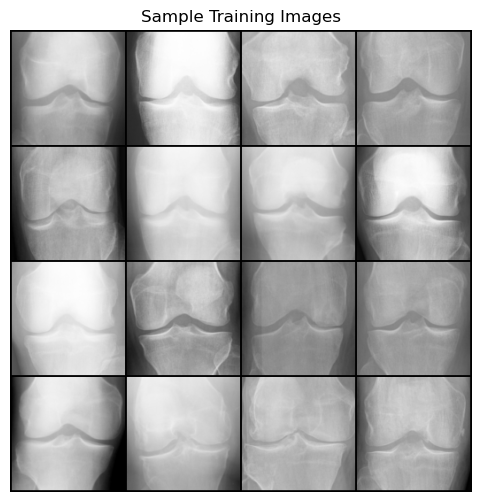

Stages: [1, 2, 0, 0, 0, 0, 2, 0]
Sides : [0, 0, 0, 0, 0, 0, 0, 0]  (0=Right, 1=Left)


In [38]:
train_ds = OAIDataset(DATA_ROOT, "train", IMG_SIZE)
val_ds   = OAIDataset(DATA_ROOT, "val", IMG_SIZE)
test_ds  = OAIDataset(DATA_ROOT, "test", IMG_SIZE)
auto_ds  = OAIDataset(DATA_ROOT, "auto_test", IMG_SIZE)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

print("Train:", len(train_ds), "Val:", len(val_ds), "Test:", len(test_ds), "Auto:", len(auto_ds))

# Visualize some samples
imgs, stages, sides = next(iter(train_loader))
grid = utils.make_grid(imgs[:16], nrow=4, normalize=True)
plt.figure(figsize=(6,6))
plt.imshow(np.transpose(grid, (1,2,0)))
plt.axis("off")
plt.title("Sample Training Images")
plt.show()

print("Stages:", stages[:8].tolist())
print("Sides :", sides[:8].tolist(), " (0=Right, 1=Left)")


In [39]:
class Generator(nn.Module):
    def __init__(self, nz=128, ngf=64, nc=1, n_stage=5, n_side=2, image_size=128):
        super().__init__()
        self.stage_emb = nn.Embedding(n_stage, n_stage)
        self.side_emb  = nn.Embedding(n_side, n_side)
        self.init_size = image_size // 16
        cond_dim = n_stage + n_side
        self.fc = nn.Linear(nz + cond_dim, ngf*8*self.init_size*self.init_size)

        def block(in_feat, out_feat):
            return nn.Sequential(
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_feat, out_feat, 3, padding=1),
                nn.BatchNorm2d(out_feat),
                nn.ReLU(True)
            )
        self.conv_blocks = nn.Sequential(
            block(ngf*8, ngf*4),
            block(ngf*4, ngf*2),
            block(ngf*2, ngf),
            block(ngf, ngf//2),
            nn.Conv2d(ngf//2, nc, 3, padding=1),
            nn.Tanh()
        )

    def forward(self, z, stage, side):
        cond = torch.cat([self.stage_emb(stage), self.side_emb(side)], dim=1)
        x = torch.cat([z, cond], dim=1)
        out = self.fc(x).view(x.size(0), -1, self.init_size, self.init_size)
        return self.conv_blocks(out)

class Discriminator(nn.Module):
    def __init__(self, ndf=64, nc=1, n_stage=5, n_side=2, image_size=128):
        super().__init__()
        self.stage_emb = nn.Embedding(n_stage, n_stage)
        self.side_emb  = nn.Embedding(n_side, n_side)

        def block(in_c, out_c, stride=2):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 4, stride, 1),
                nn.BatchNorm2d(out_c),
                nn.LeakyReLU(0.2, inplace=True)
            )
        self.model = nn.Sequential(
            nn.Conv2d(nc+1, ndf, 4, 2, 1), nn.LeakyReLU(0.2, inplace=True),
            block(ndf, ndf*2),
            block(ndf*2, ndf*4),
            block(ndf*4, ndf*8),
            nn.Conv2d(ndf*8, 1, 4, 1)
        )

    def forward(self, x, stage, side):
        B, _, H, W = x.shape
        cond = torch.cat([self.stage_emb(stage), self.side_emb(side)], dim=1)
        emb_map = cond.unsqueeze(-1).unsqueeze(-1).expand(-1, cond.size(1), H, W).sum(1, keepdim=True)
        out = self.model(torch.cat([x, emb_map], 1))
        return out.mean(dim=[1,2,3])  # scalar per image


In [40]:
# Instantiate models after defining Generator and Discriminator
netG = Generator(NZ, n_stage=N_STAGES, n_side=N_SIDES).to(DEVICE)
netD = Discriminator(n_stage=N_STAGES, n_side=N_SIDES).to(DEVICE)

optG = torch.optim.Adam(netG.parameters(), lr=LR, betas=(0.5, 0.999))
optD = torch.optim.Adam(netD.parameters(), lr=LR, betas=(0.5, 0.999))
criterion = nn.BCEWithLogitsLoss()

# fixed noise & labels for monitoring
fixed_noise = torch.randn(N_STAGES * N_SIDES * 2, NZ, device=DEVICE)
fixed_stage = torch.tensor([s for s in range(N_STAGES) for _ in range(N_SIDES*2)], device=DEVICE)
fixed_side  = torch.tensor([side for _ in range(N_STAGES) for side in [0,1,0,1]], device=DEVICE)


In [41]:
for epoch in range(1, EPOCHS+1):
    netG.train()
    netD.train()

    for imgs, stages, sides in train_loader:
        imgs, stages, sides = imgs.to(DEVICE), stages.to(DEVICE), sides.to(DEVICE)
        B = imgs.size(0)
        valid, fake = torch.ones(B, device=DEVICE), torch.zeros(B, device=DEVICE)

        # ---------------- Train D ----------------
        optD.zero_grad()
        real_loss = criterion(netD(imgs, stages, sides), valid)
        z = torch.randn(B, NZ, device=DEVICE)
        gen_imgs = netG(z, stages, sides)
        fake_loss = criterion(netD(gen_imgs.detach(), stages, sides), fake)
        d_loss = 0.5 * (real_loss + fake_loss)
        d_loss.backward()
        optD.step()

        # ---------------- Train G ----------------
        optG.zero_grad()
        g_loss = criterion(netD(gen_imgs, stages, sides), valid)
        g_loss.backward()
        optG.step()

    # ---------------- Save Samples every 50 epochs ----------------
    if epoch % 50 == 0:
        with torch.no_grad():
            netG.eval()
            sample = netG(fixed_noise, fixed_stage, fixed_side).cpu()
            grid = utils.make_grid((sample+1)/2, nrow=8)
            utils.save_image(grid, f"{SAVE_DIR}/samples_epoch_{epoch:03d}.png")

    # ---------------- Save Model Checkpoints every 100 epochs ----------------
    if epoch % 100 == 0:
        torch.save({
            "epoch": epoch,
            "netG_state_dict": netG.state_dict(),
            "netD_state_dict": netD.state_dict(),
            "optG_state_dict": optG.state_dict(),
            "optD_state_dict": optD.state_dict(),
            "g_loss": g_loss.item(),
            "d_loss": d_loss.item()
        }, f"{SAVE_DIR}/checkpoint_epoch_{epoch:03d}.pth")

    print(f"Epoch {epoch}/{EPOCHS} - D_loss: {d_loss.item():.3f}, G_loss: {g_loss.item():.3f}")


Epoch 1/500 - D_loss: 0.663, G_loss: 0.742
Epoch 2/500 - D_loss: 0.686, G_loss: 0.791
Epoch 3/500 - D_loss: 0.703, G_loss: 0.698
Epoch 4/500 - D_loss: 0.704, G_loss: 0.685
Epoch 5/500 - D_loss: 0.703, G_loss: 0.700
Epoch 6/500 - D_loss: 0.696, G_loss: 0.707
Epoch 7/500 - D_loss: 0.689, G_loss: 0.704
Epoch 8/500 - D_loss: 0.682, G_loss: 0.763
Epoch 9/500 - D_loss: 0.687, G_loss: 0.709
Epoch 10/500 - D_loss: 0.672, G_loss: 0.734
Epoch 11/500 - D_loss: 0.691, G_loss: 0.707
Epoch 12/500 - D_loss: 0.694, G_loss: 0.747
Epoch 13/500 - D_loss: 0.712, G_loss: 0.722
Epoch 14/500 - D_loss: 0.705, G_loss: 0.718
Epoch 15/500 - D_loss: 0.702, G_loss: 0.706
Epoch 16/500 - D_loss: 0.687, G_loss: 0.707
Epoch 17/500 - D_loss: 0.692, G_loss: 0.698
Epoch 18/500 - D_loss: 0.702, G_loss: 0.722
Epoch 19/500 - D_loss: 0.693, G_loss: 0.677
Epoch 20/500 - D_loss: 0.683, G_loss: 0.771
Epoch 21/500 - D_loss: 0.698, G_loss: 0.705
Epoch 22/500 - D_loss: 0.737, G_loss: 0.701
Epoch 23/500 - D_loss: 0.694, G_loss: 0.7

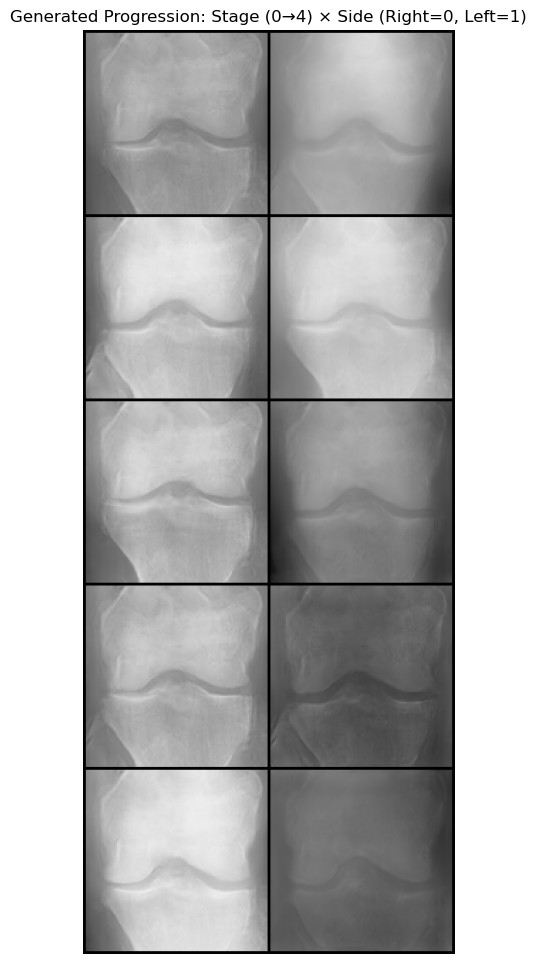

In [42]:
# --------------------------
# Final Visualization: 5 (stages) × 2 (sides)
# --------------------------

netG.eval()

with torch.no_grad():
    # Build grid of latent vectors: one per stage × side
    z = torch.randn(N_STAGES * N_SIDES, NZ, device=DEVICE)

    stages = torch.tensor([s for s in range(N_STAGES) for _ in range(N_SIDES)], device=DEVICE)
    sides  = torch.tensor([side for _ in range(N_STAGES) for side in [0, 1]], device=DEVICE)

    gen_imgs = netG(z, stages, sides).cpu()
    gen_imgs = (gen_imgs + 1) / 2  # [-1,1] → [0,1]

    grid = utils.make_grid(gen_imgs, nrow=N_SIDES, normalize=False)

    plt.figure(figsize=(6, 12))
    plt.imshow(np.transpose(grid, (1,2,0)))
    plt.axis("off")
    plt.title("Generated Progression: Stage (0→4) × Side (Right=0, Left=1)")
    plt.show()


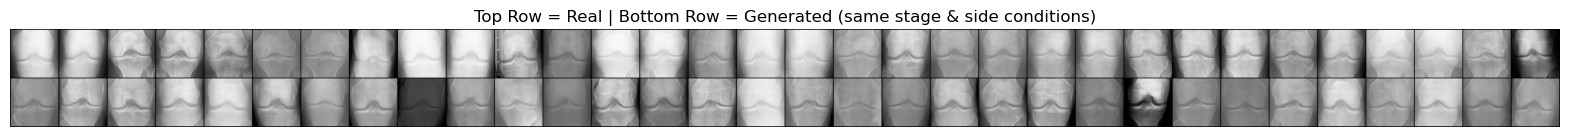

In [33]:
# --------------------------
# Compare Real vs Generated Samples
# --------------------------

netG.eval()

# Take a small batch from validation set
real_imgs, real_stages, real_sides = next(iter(val_loader))
real_imgs, real_stages, real_sides = real_imgs.to(DEVICE), real_stages.to(DEVICE), real_sides.to(DEVICE)

# Generate using same (stage, side) conditions as real images
with torch.no_grad():
    z = torch.randn(real_imgs.size(0), NZ, device=DEVICE)
    gen_imgs = netG(z, real_stages, real_sides).cpu()
    gen_imgs = (gen_imgs + 1) / 2  # scale to [0,1]

# Prepare real images (also scale to [0,1] for plotting)
real_imgs_disp = (real_imgs.cpu() + 1) / 2

# Build side-by-side grid: first row real, second row generated
comparison = torch.cat([real_imgs_disp, gen_imgs], dim=0)
grid = utils.make_grid(comparison, nrow=real_imgs.size(0), normalize=False)

plt.figure(figsize=(20, 6))
plt.imshow(np.transpose(grid, (1,2,0)))
plt.axis("off")
plt.title("Top Row = Real | Bottom Row = Generated (same stage & side conditions)")
plt.show()


In [34]:
!pip install torchmetrics pytorch-ssim --quiet


  DEPRECATION: Building 'pytorch-ssim' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'pytorch-ssim'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [40]:
pip install torchmetrics[image] torch-fidelity --quiet


Note: you may need to restart the kernel to use updated packages.


In [60]:
# Load checkpoint
checkpoint = torch.load(f"{SAVE_DIR}/checkpoint_epoch_200.pth", map_location=DEVICE)

# Recreate models
netG = Generator(NZ, n_stage=N_STAGES, n_side=N_SIDES).to(DEVICE)
netD = Discriminator(n_stage=N_STAGES, n_side=N_SIDES).to(DEVICE)

netG.load_state_dict(checkpoint["netG_state_dict"])
netD.load_state_dict(checkpoint["netD_state_dict"])
netG.eval()

print(f"Checkpoint loaded (epoch {checkpoint['epoch']})")


Checkpoint loaded (epoch 200)


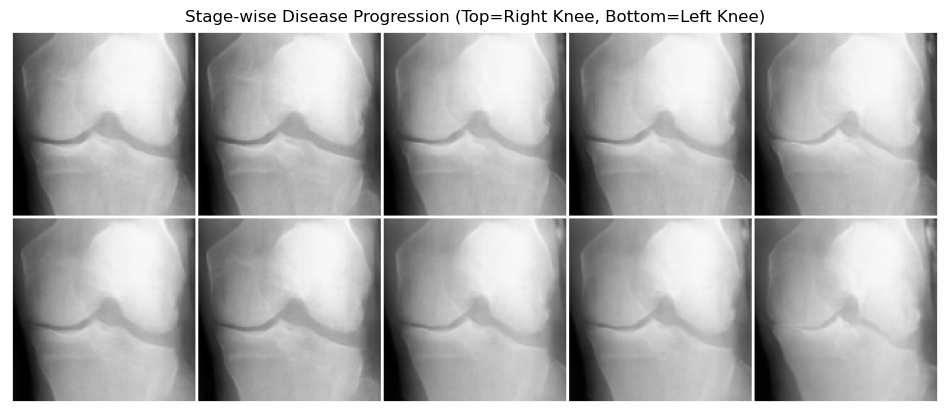

In [61]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt

def generate_progression(netG, z=None, save_path=None):
    netG.eval()
    if z is None:
        z = torch.randn(1, NZ, device=DEVICE)  # one random patient

    images = []
    with torch.no_grad():
        for side in [0, 1]:   # right=0, left=1
            row_imgs = []
            for stage in range(N_STAGES):  # stages 0..4
                stage_t = torch.tensor([stage], device=DEVICE)
                side_t  = torch.tensor([side], device=DEVICE)
                img = netG(z, stage_t, side_t).cpu()
                img = (img + 1) / 2.0  # back to [0,1]
                row_imgs.append(img)
            images.append(torch.cat(row_imgs, dim=0))

    # Stack into grid: 2 rows (sides), 5 cols (stages)
    grid = vutils.make_grid(torch.cat(images, dim=0), nrow=N_STAGES, normalize=False, pad_value=1)

    plt.figure(figsize=(12, 5))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.axis("off")
    plt.title("Stage-wise Disease Progression (Top=Right Knee, Bottom=Left Knee)")
    plt.show()

    if save_path:
        vutils.save_image(grid, save_path)

# Example usage
z_patient = torch.randn(1, NZ, device=DEVICE)
generate_progression(netG, z_patient, save_path=f"{SAVE_DIR}/progression_patient.png")


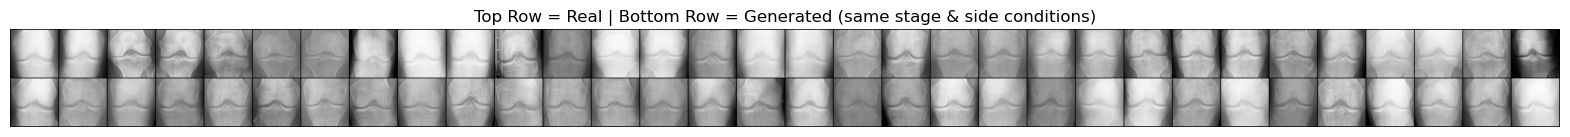

In [62]:
# --------------------------
# Compare Real vs Generated Samples
# --------------------------

netG.eval()

# Take a small batch from validation set
real_imgs, real_stages, real_sides = next(iter(val_loader))
real_imgs, real_stages, real_sides = real_imgs.to(DEVICE), real_stages.to(DEVICE), real_sides.to(DEVICE)

# Generate using same (stage, side) conditions as real images
with torch.no_grad():
    z = torch.randn(real_imgs.size(0), NZ, device=DEVICE)
    gen_imgs = netG(z, real_stages, real_sides).cpu()
    gen_imgs = (gen_imgs + 1) / 2  # scale to [0,1]

# Prepare real images (also scale to [0,1] for plotting)
real_imgs_disp = (real_imgs.cpu() + 1) / 2

# Build side-by-side grid: first row real, second row generated
comparison = torch.cat([real_imgs_disp, gen_imgs], dim=0)
grid = utils.make_grid(comparison, nrow=real_imgs.size(0), normalize=False)

plt.figure(figsize=(20, 6))
plt.imshow(np.transpose(grid, (1,2,0)))
plt.axis("off")
plt.title("Top Row = Real | Bottom Row = Generated (same stage & side conditions)")
plt.show()


In [65]:
import glob

def load_real_progression(patient_id, side, data_root, stages=[0,1,2,3,4]):
    images = []
    for stage in stages:
        stage_dir = os.path.join(data_root, "train", str(stage))
        # match both .png and .PNG
        matches = glob.glob(os.path.join(stage_dir, f"{patient_id}_{side}.*"))
        
        if len(matches) > 0:
            fpath = matches[0]
            img = Image.open(fpath).convert("L")
            img = img.resize((128,128))
            img = np.array(img) / 255.0
            images.append(img)
        else:
            print(f"⚠️ Missing: patient {patient_id}, side {side}, stage {stage}")
            images.append(np.zeros((128,128)))
    return images

C:\Users\Sanjjey Arumugam\.cache\kagglehub\datasets\jeftaadriel\osteoarthritis-initiative-oai-dataset\versions\1
9003175_1.png
C:\Users\Sanjjey Arumugam\.cache\kagglehub\datasets\jeftaadriel\osteoarthritis-initiative-oai-dataset\versions\1\auto_test\0
9003175_1.png
C:\Users\Sanjjey Arumugam\.cache\kagglehub\datasets\jeftaadriel\osteoarthritis-initiative-oai-dataset\versions\1\auto_test\1
9003175_1.png
C:\Users\Sanjjey Arumugam\.cache\kagglehub\datasets\jeftaadriel\osteoarthritis-initiative-oai-dataset\versions\1\auto_test\2
9003175_1.png
C:\Users\Sanjjey Arumugam\.cache\kagglehub\datasets\jeftaadriel\osteoarthritis-initiative-oai-dataset\versions\1\auto_test\3
9003175_1.png
C:\Users\Sanjjey Arumugam\.cache\kagglehub\datasets\jeftaadriel\osteoarthritis-initiative-oai-dataset\versions\1\auto_test\4


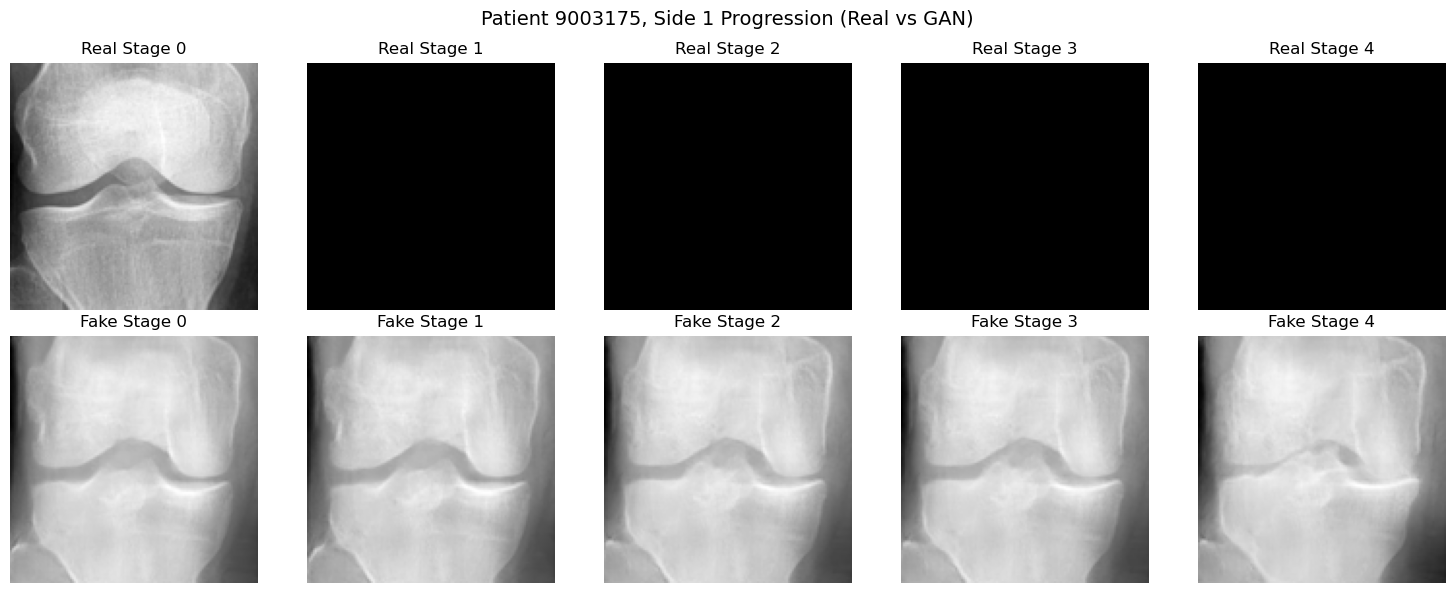

In [69]:
import os
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from PIL import Image
import numpy as np

# Function to load real images for a given patient_id and side
def load_real_progression(patient_id, side, data_root, stages=[0,1,2,3,4]):
    images = []
    for stage in stages:
        stage_dir = os.path.join(data_root, "auto_test", str(stage))  # adjust if you want val/test
        fname = f"{patient_id}_{side}.png"
        print(fname)
        print(stage_dir)
        fpath = os.path.join(stage_dir, fname)
        if os.path.exists(fpath):
            img = Image.open(fpath).convert("L")  # grayscale
            img = img.resize((128,128))  # resize to match GAN output
            img = np.array(img) / 255.0
            images.append(img)
        else:
            # if missing, append blank
            images.append(np.zeros((128,128)))
    return images

# Function to generate progression from GAN
def generate_fake_progression(netG, z, side, stages=[0,1,2,3,4]):
    images = []
    with torch.no_grad():
        for stage in stages:
            stage_t = torch.tensor([stage], device=DEVICE)
            side_t  = torch.tensor([side], device=DEVICE)
            img = netG(z, stage_t, side_t).cpu()
            img = (img + 1) / 2.0  # scale to [0,1]
            img = img.squeeze(0).permute(1,2,0).numpy()
            images.append(img)
    return images

# Function to plot real vs fake progression
def compare_progression(patient_id, side, data_root, netG, z=None, save_path=None):
    if z is None:
        z = torch.randn(1, NZ, device=DEVICE)
    
    real_imgs = load_real_progression(patient_id, side, data_root)
    fake_imgs = generate_fake_progression(netG, z, side)

    fig, axes = plt.subplots(2, len(real_imgs), figsize=(15, 6))
    
    for i in range(len(real_imgs)):
        axes[0, i].imshow(real_imgs[i], cmap="gray")
        axes[0, i].axis("off")
        axes[0, i].set_title(f"Real Stage {i}")
        
        axes[1, i].imshow(fake_imgs[i].squeeze(), cmap="gray")
        axes[1, i].axis("off")
        axes[1, i].set_title(f"Fake Stage {i}")
    
    plt.suptitle(f"Patient {patient_id}, Side {side} Progression (Real vs GAN)", fontsize=14)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

# Example usage:
data_root = path  # from kagglehub download
print(data_root)
patient_id = "9003175"
side = 1  # right knee (use 2 for left)
compare_progression(patient_id, side, data_root, netG, save_path=f"{SAVE_DIR}/real_vs_fake.png")


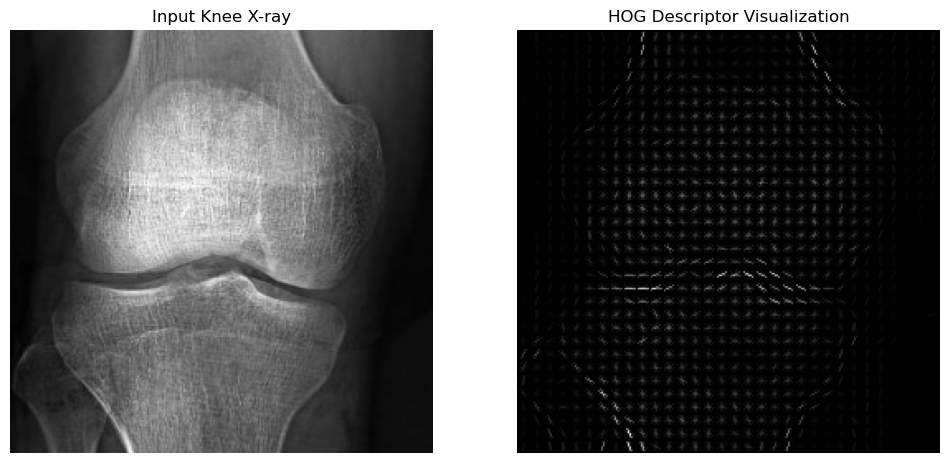

The HOG feature vector has a length of: 34596


In [4]:
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure
from skimage.transform import resize
import skimage.io # Using skimage.io to read the image file
import numpy as np

# --- 1. Load your local image ---
# Use a raw string (r"...") to handle the Windows file path correctly.
image_path = r"C:\Users\Sanjjey Arumugam\Downloads\the-normal-knee-x-ray-what-are-its-features.jpg"

# Read the image in grayscale format
try:
    image = skimage.io.imread(image_path, as_gray=True)
except FileNotFoundError:
    print(f"Error: The file was not found at the path: {image_path}")
    # Exit or handle the error appropriately
    exit()


# --- 2. Preprocess the image ---
# Resize image to a standard size for consistent feature vector length
# Using a square size as it's more typical for X-rays
image_resized = resize(image, (256, 256)) 

# --- 3. HOG Feature Extraction ---
# fd is the HOG feature vector
# hog_image is a visualization of the gradients
# Note: 'channel_axis' is removed because this is now a 2D (grayscale) image
fd, hog_image = hog(image_resized, 
                    orientations=9, 
                    pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), 
                    visualize=True)

# --- 4. Display the results ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

# Display original resized image
ax1.axis('off')
ax1.imshow(image_resized, cmap=plt.cm.gray)
ax1.set_title('Input Knee X-ray')

# Rescale HOG image for better visualization
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# Display HOG image
ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('HOG Descriptor Visualization')

plt.show()

# The `fd` variable now holds the HOG feature vector for the image
print(f"The HOG feature vector has a length of: {fd.shape[0]}")